In [1]:
import pandas as pd
import numpy as np
import math
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold

import platform
from os import listdir
from os.path import isfile, join
from glob import glob
from pathlib import Path
import sys
import os
import copy
import traceback
from pathlib import Path


import matplotlib.pyplot as plt

import SMOTE
import feature_selector
import DE
import CFS
import birch
import metrics.abcd

import metrices
import measures

import sys
import traceback
import warnings
warnings.filterwarnings("ignore")

ModuleNotFoundError: No module named 'SMOTE'

In [ ]:
def prepare_data(path):
    df = pd.read_csv(path)
    df = df.drop(labels = ['Host','Vcs','Project','File','PL','IssueTracking'],axis=1)
    df = df.dropna()
    df = df[['TLOC', 'TNF', 'TNC', 'TND', 'LOC', 'CL', 'NStmt', 'NFunc',
       'RCC', 'MNL', 'avg_WMC', 'max_WMC', 'total_WMC', 'avg_DIT', 'max_DIT',
       'total_DIT', 'avg_RFC', 'max_RFC', 'total_RFC', 'avg_NOC', 'max_NOC',
       'total_NOC', 'avg_CBO', 'max_CBO', 'total_CBO', 'avg_DIT.1',
       'max_DIT.1', 'total_DIT.1', 'avg_NIV', 'max_NIV', 'total_NIV',
       'avg_NIM', 'max_NIM', 'total_NIM', 'avg_NOM', 'max_NOM', 'total_NOM',
       'avg_NPBM', 'max_NPBM', 'total_NPBM', 'avg_NPM', 'max_NPM', 'total_NPM',
       'avg_NPRM', 'max_NPRM', 'total_NPRM', 'avg_CC', 'max_CC', 'total_CC',
       'avg_FANIN', 'max_FANIN', 'total_FANIN', 'avg_FANOUT', 'max_FANOUT',
       'total_FANOUT', 'NRev', 'NFix', 'avg_AddedLOC', 'max_AddedLOC',
       'total_AddedLOC', 'avg_DeletedLOC', 'max_DeletedLOC',
       'total_DeletedLOC', 'avg_ModifiedLOC', 'max_ModifiedLOC',
       'total_ModifiedLOC','Buggy']]
    return df

def get_features(df):
    fs = feature_selector.featureSelector()
    df,_feature_nums,features = fs.cfs_bfs(df)
    return df,features

def apply_cfs(df):
    y = df.Buggy.values
    X = df.drop(labels = ['Buggy'],axis = 1)
    X = X.values
    selected_cols = CFS.cfs(X,y)
    cols = df.columns[[selected_cols]].tolist()
    cols.append('Buggy')
    return df[cols],cols
    
def apply_smote(df):
    cols = df.columns
    smt = SMOTE.smote(df)
    df = smt.run()
    df.columns = cols
    return df

def load_data(path,target):
    df = pd.read_csv(path)
    if path == 'data/jm1.csv':
        df = df[~df.uniq_Op.str.contains("\?")]
    y = df[target]
    X = df.drop(labels = target, axis = 1)
    X = X.apply(pd.to_numeric)
    return X,y

# Cluster Driver
def cluster_driver(df,print_tree = True):
    X = df.apply(pd.to_numeric)
    cluster = birch.birch(branching_factor=20)
    #X.set_index('Project Name',inplace=True)
    cluster.fit(X)
    cluster_tree,max_depth = cluster.get_cluster_tree()
    #cluster_tree = cluster.model_adder(cluster_tree)
    if print_tree:
        cluster.show_clutser_tree()
    return cluster,cluster_tree,max_depth

In [2]:
def bellwether(selected_projects,all_projects):
    size = []
    buggy = []
    LOC = []
    file = []
    count = 0
    for s_project in selected_projects:
        try:
            s_path = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted/' + s_project
            df = prepare_data(s_path)
            if df.shape[0] < 50:
                continue
            else:
                count+=1
            size.append(df.shape[0])
            _df = df[df['Buggy'] == 'buggy']
            buggy.append(_df.shape[0]/df.shape[0])
            LOC.append(df.TLOC.unique()[0]/1000)
            print(df)
            file.append(df.File.nunique())
        except:
            continue
    return size,buggy,LOC,file
            
            

In [3]:
data_source1 = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/converted'
if platform.system() == 'Darwin' or platform.system() == 'Linux':
    _dir = data_source1 + '/'
else:
    _dir = data_source1 + '\\'
projects = [f for f in listdir(_dir) if isfile(join(_dir, f))]
size,buggy,LOC,file = bellwether(projects,projects)

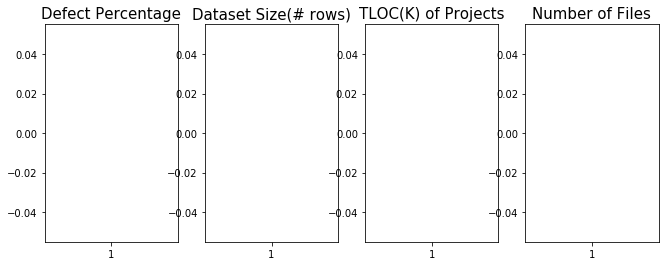

In [4]:
fig = plt.figure(num=None, figsize = (11,4), facecolor='w', edgecolor='k')

ax = fig.add_subplot(141)
bplot1 = ax.boxplot(buggy,patch_artist = True,showfliers=False)
ax.set_title('Defect Percentage',size = 15)

#colors = [(0/255,193/255,195/255)]
colors = [(128/255,128/255,128/255)]
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot1['medians']:
    median.set(color='black', linewidth=1)


ax = fig.add_subplot(142)
bplot1 = ax.boxplot(size,patch_artist = True,showfliers=False)
ax.set_title('Dataset Size(# rows)',size = 15)

colors = [(128/255,128/255,128/255)]
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot1['medians']:
    median.set(color='black', linewidth=2)
    
ax = fig.add_subplot(143)
bplot1 = ax.boxplot(LOC,patch_artist = True,showfliers=False)
ax.set_title('TLOC(K) of Projects',size = 15)

colors = [(128/255,128/255,128/255)]
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot1['medians']:
    median.set(color='black', linewidth=2)
    
ax = fig.add_subplot(144)
bplot1 = ax.boxplot(file,patch_artist = True,showfliers=False)
ax.set_title('Number of Files',size = 15)

colors = [(128/255,128/255,128/255)]
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
for median in bplot1['medians']:
    median.set(color='black', linewidth=2)


plt.show()
fig.savefig('meta.pdf',format='pdf')

In [8]:
data_source = '/Users/suvodeepmajumder/Documents/AI4SE/bellwether_comminity/data/1385/original/rawMetrics.csv'
df = pd.read_csv(data_source)
unique_projects = df.Project.unique()
project_file = []
for project in unique_projects:
    _df = df[df['Project'] == project]
    if(_df.shape[0] <= 50):
        continue
    project_file.append([project,_df.File.unique().shape[0],_df.PL.unique()[0],_df.TLOC.unique().shape[0]])
project_file_df = pd.DataFrame(project_file,columns = ['project','num_files','lang','LOC'])
project_file_df.groupby(['lang']).count()

,project,num_files,LOC
lang,,,
c,116,116,116
cpp,241,241,241
cs,42,42,42
java,290,290,290
pascal,6,6,6


In [37]:
file = project_file_df.num_files.values.tolist()

In [80]:
df = pd.read_csv('hyp.csv')

In [74]:
df

,projecs,Bellwethe,BUBBLE
0,100,7,0
1,200,30,0
2,400,120,0
3,800,479,1
4,1600,1915,1
5,3200,7660,2
6,6400,30638,5
7,12800,122552,10


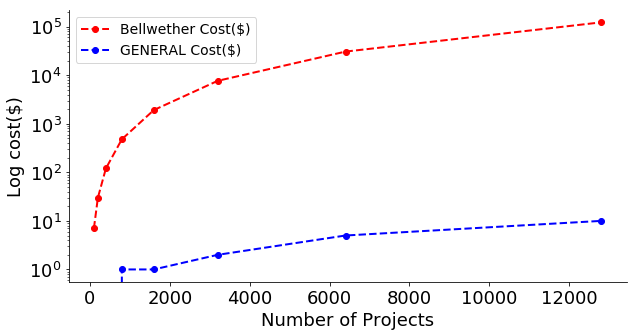

In [78]:
fig, ax = plt.subplots(figsize=(10, 5)) 
x = df.projecs.values.tolist()
plot = plt.plot(x,df.Bellwethe.values.tolist(),marker='o', linestyle='--', color='r', linewidth='2',
label='Bellwether Cost($)')
plot = plt.plot(x,df.BUBBLE.values.tolist(),marker='o', linestyle='--', color='b', linewidth='2',
label='GENERAL Cost($)')
plt.yscale('log')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Number of Projects',fontsize=18)
plt.ylabel('Log cost($)',fontsize=18) 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=14) 
plt.savefig('cost.pdf',dpi=600)

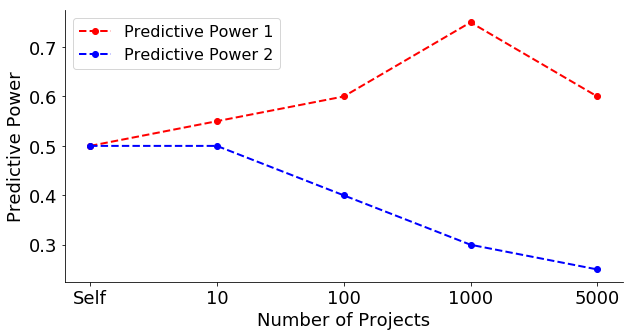

In [81]:
fig, ax = plt.subplots(figsize=(10, 5)) 
x = df.Projects.values.tolist()
plot = plt.plot(x,df.Predictive1.values.tolist(),marker='o', linestyle='--', color='r', linewidth='2',
label='Predictive Power 1')
plot = plt.plot(x,df.Predictive2.values.tolist(),marker='o', linestyle='--', color='b', linewidth='2',
label='Predictive Power 2')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Number of Projects',fontsize=18)
plt.ylabel('Predictive Power',fontsize=18) 
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.legend(fontsize=16) 
plt.savefig('predictive_power.pdf',dpi=600)

In [60]:
df

,Projects,Predictive1,Predictive2
0,Self,0.50,0.50
1,10,0.55,0.50
2,100,0.60,0.40
3,1000,0.75,0.30
4,5000,0.60,0.25
